In [200]:
import scipy.io

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd

import numpy as np

from game import Game
from strategies import FastAttractorMemory
from memory import FastAttractor

import torch
from tqdm import tqdm

from fiftyone import ViewField as F

import math

In [201]:
n_trials = 20

steps = 10

size_range = [[3,3], [4,4], [5,5], [6,6], [7,7]]

In [202]:
def play_strategy(strategy, game, max_steps=500):
    win = False
    steps = 0
    while not win and steps < max_steps:
        strategy.pick()
        win = game.check_win()
        torch.cuda.empty_cache()
        steps+=1

In [203]:
def collect_data(n_trials, size_range, game, lr, rr):
    dfs = []
    tot_clicks = []
    for size in size_range: 
        size_clicks = []
        for n in tqdm(range(n_trials), desc=f'Size: {size}'):
            game.set_size(size, 2)
            dim = np.prod(size) + len(np.unique(game.get_grid_labels()))
            # dim = 74
            memory = FastAttractor(dim, lr, rr)
            strategy = FastAttractorMemory(game, memory, steps=steps)
            play_strategy(strategy, game)
            df, nc = game.get_metrics()
            dfs.append(df)
            size_clicks.append(nc)
        tot_clicks.append(size_clicks)
    return pd.concat(dfs).reset_index(drop=True), tot_clicks

In [204]:
def get_second_click_df(df):
    o_df = pd.DataFrame()
    o_df['match'] = df['match'].to_numpy()[1::2]
    o_df['random_match'] = df['random_match'].to_numpy()[1::2]
    o_df['board_size'] = df['board_size'].to_numpy()[1::2]
    o_df['tile_clicked'] = df['tile_clicked'].to_numpy()[1::2]
    o_df['nslc'] = df['nslc'].to_numpy()[1::2]
    o_df['nsp'] = df['nsp'].to_numpy()[1::2]
    o_df['correct_tile'] = df['correct_tile'].to_numpy()[0::2]
    return o_df

In [205]:
game = Game(
            dataset_name='coco-2017', 
            split='validation', 
            field="ground_truth", 
            ds_filter=F("supercategory").is_in(('person', 'animal', 'food', 'vehicle', 'indoor')),
            dataset_dir ="/home/ravi/datasets/coco-2017",
        )

Found annotations at '/home/ravi/datasets/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [206]:
att_df, tot_clicks = collect_data(n_trials, size_range, game, 0.5, 0.9)
att_df = get_second_click_df(att_df)

Size: [7, 7]: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


# Heatmaps

In [210]:
def plot_error_location(df):
    mm_df = df[df['match'] == 0]
    b_grouped = mm_df.groupby('board_size')
    for board_size, b_group in b_grouped:
        N = int(np.sqrt(board_size))
        counts = np.bincount(b_group['tile_clicked'].to_numpy(), minlength=board_size)
        input = np.reshape(counts/counts.sum(), (N, N))
        plt.figure() 
        sns.heatmap(input, annot=True, cmap='magma', square=True, cbar=True, cbar_kws={'label': 'Mismatch Frequency'})    

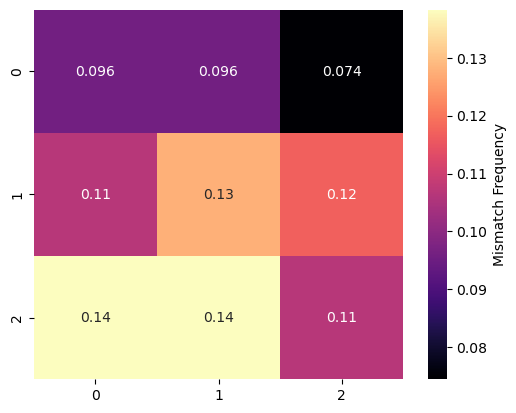

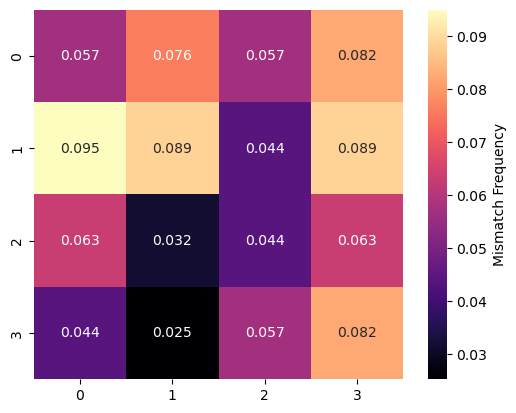

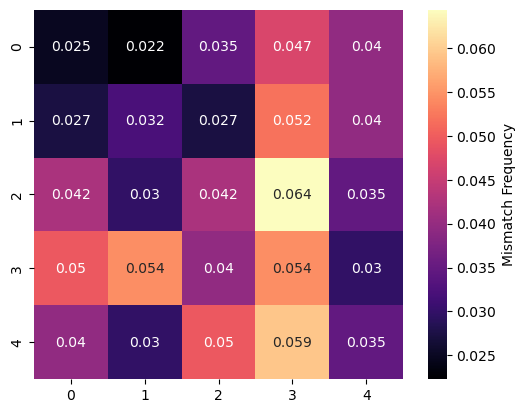

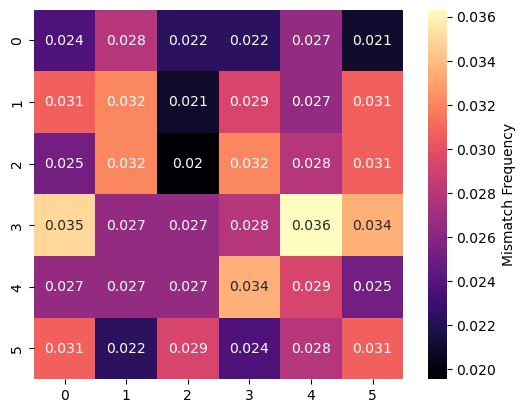

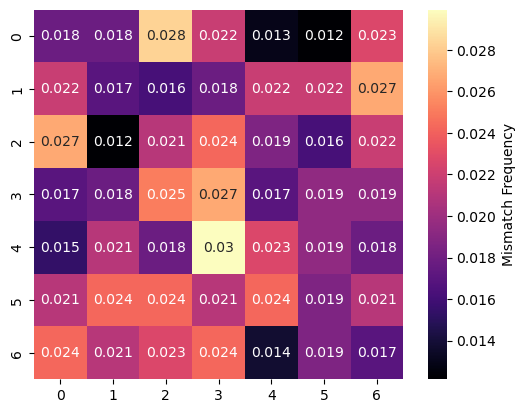

In [211]:
plot_error_location(att_df)

In [212]:
def plot_error_location_diff(df):
    b_grouped = df.groupby('board_size')
    for board_size, b_group in b_grouped:
        N = int(np.sqrt(board_size))
        m_df = b_group[b_group['match']==1]
        m_counts = np.bincount(m_df['tile_clicked'].to_numpy(), minlength=board_size)
        mm_df = b_group[b_group['match']==0]
        mm_counts = np.bincount(mm_df['tile_clicked'].to_numpy(), minlength=board_size)
        input = np.reshape((mm_counts/mm_counts.sum()) - (m_counts/m_counts.sum()), (N, N))
        plt.figure() 
        sns.heatmap(input, annot=False, cmap='coolwarm', square=True, cbar=True, cbar_kws={'label': 'Match v Mismatch Frequency'})

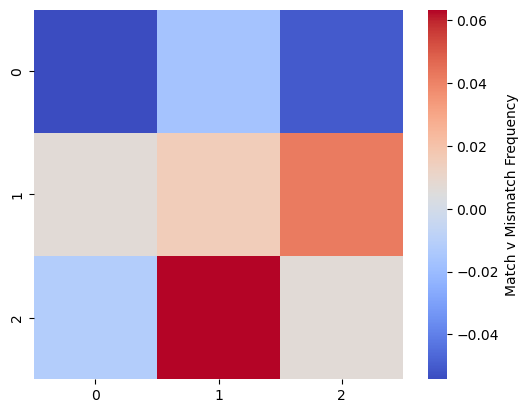

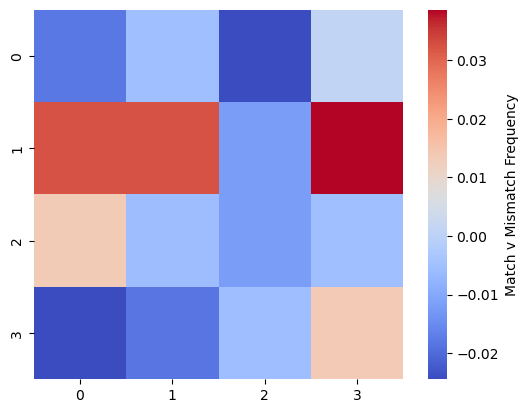

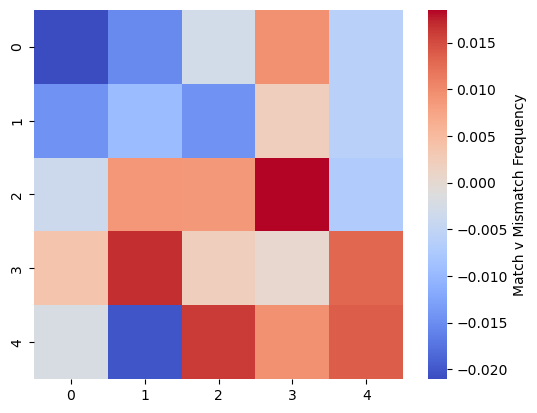

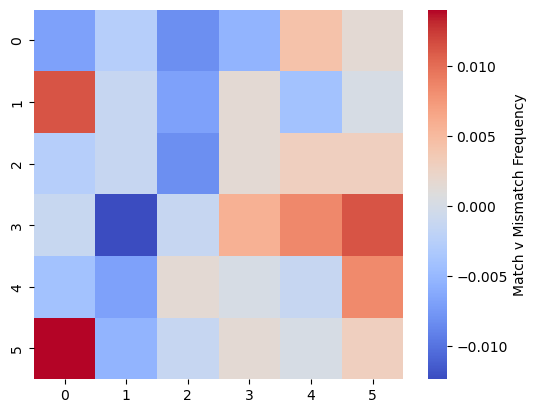

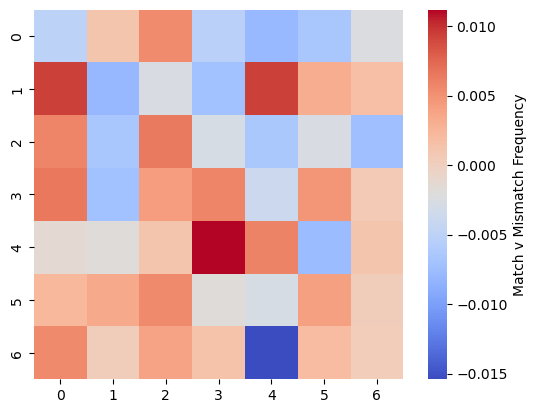

In [213]:
plot_error_location_diff(att_df)

# Positional distance

In [214]:
def euclidean_distance(row):
    N = int(np.sqrt(row['board_size']))
    # Convert 1D indices to 2D coordinates
    x1, y1 = np.unravel_index(row['tile_clicked'], (N, N))
    x2, y2 = np.unravel_index(row['correct_tile'], (N, N))
    
    # Compute Euclidean distance
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    return distance

In [215]:
def plot_error_distance(df):
    mm_df = df[df['match'] == 0]
    mm_df = mm_df[mm_df['correct_tile'] != -1]
    mm_df['distance'] = mm_df.apply(euclidean_distance, axis=1)
    mm_df['board_size'] = mm_df['board_size'].apply(np.sqrt)
    plt.figure(figsize=(8, 16))
    palette = ['grey']
    ax = sns.catplot(x="board_size", y="distance", data=mm_df, aspect=0.85, kind='bar', palette=palette)
    ax.set(xlabel="Board size", ylabel="distance-from-correct")
    plt.show()

<Figure size 800x1600 with 0 Axes>

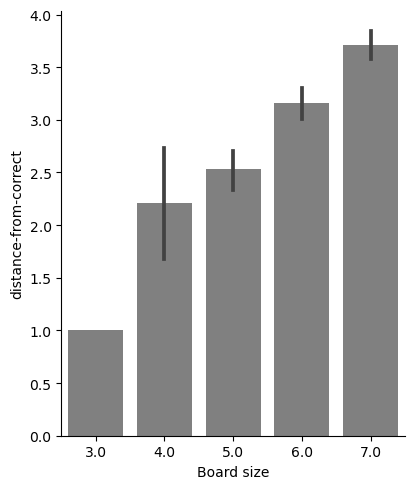

In [216]:
plot_error_distance(att_df)